<center>
    <h3>Modelos Descriptivos y Predictivos II - Grado en Ciencia de Datos</h3>
    <h3>Universitat Politècnica de València</h3>
    <h1>Práctica 4: Máquinas de Soporte Vectorial (SVM)</h1>
    <h2>Sesión 2</h2>
</center>

### Objetivos formativos:

- Entender los conceptos fundamentales del clasificador SVM y saber aplicarlo en distintas tareas, tanto sintéticas como reales.
- Saber encontrar los hiperparámetros óptimos para una tarea determinada.
- Aplicar SVM a tareas tanto binarias como multiclase.

### Importación de módulos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, make_blobs, make_circles, load_wine, load_breast_cancer
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

### Creación de datasets artificiales

En esta práctica usaremos algunos conjuntos de datos creados de manera artificial. A continuación se da el código de distintas funciones para crear estos datasets:
- `create_dataset_linear`: genera puntos n-dimensionales en dos grupos (blobs) con centroides en (-1,-1,...,-1) y (1,1,...,1).<br>**Parámetros:**
    - `samples`: número de puntos a generar.
    - `std`: dispersión (desviación estándar) de los puntos en cada grupo. Puede ser un `float` (todos los grupos tienen la misma dispersión) o un array (permite especificar una dispersión distinta para cada grupo).
    - `n_features`: dimensión de los puntos generados.
- `create_dataset_moons`: genera puntos 2D en dos grupos con formas de media luna.<br>**Parámetros:**
    - `samples`: número de puntos a generar.
    - `noise`: ruido de las muestras. A mayor ruido, mayor solapamiento entre las muestras de ambos grupos.

- `create_dataset_poly`: genera puntos 2D en dos grupos separados por una frontera poligonal<br>**Parámetros:**
    - `coefs`: coeficientes del polígono que define la frontera.
    - `samples`: número de puntos a generar.
    - `noise`: ruido de las muestras. A mayor ruido, mayor solapamiento entre las muestras de ambos grupos.
    - `box`: tamaño del cuadrado en el que se enmarcan los puntos.


**Funciones generadoras de datos**

In [2]:
def create_dataset_linear(samples=300, std=0.5, n_features=2): 
    # Generar un conjunto de datos linealmente separable
    X, y = make_blobs(n_samples=samples, centers=[[-1]*n_features, [1]*n_features] , n_features=n_features, cluster_std=std, random_state=17)
    return X, y

def create_dataset_moons(samples=300, noise=0.1):
    # Generar un conjunto de datos con clases en forma de dos lunas
    X, y = make_moons(n_samples=samples, noise=noise, random_state=32)
    return X, y

def create_dataset_poly(coefs, samples=300, noise=0.1, box=20):
    np.random.seed(32)
    X = np.random.uniform(-box/2, box/2, (samples, 2))
    y = np.zeros(samples)
    grade = len(coefs)-1
    for i, p in enumerate(X):
        px,py = p[0],p[1]
        y_poly = sum(coef * (px ** (grade-j)) for j, coef in enumerate(coefs))
        y_noisy = y_poly + np.random.uniform(-noise, noise)*box
        y[i] = 0 if y_noisy < py else 1
    return X, y

### Ejercicio 4. Problemas con más de dos clases

Aunque el lasificador SVM está pensado para clasificación binaria, es posible abordar problemas con más de dos clases mediante estrategias como **one-vs-one (OvO)** o **one-vs-rest (OvR)**.

- **one-vs-one:** Para un problema de $k$ clases se entrenan $\frac{k(k-1)}{2}$ clasificadores, cada uno para una pareja de clases.
- **one-vs-rest:** Para $k$ clases se entrenan $k$ clasificadores, cada uno para separar una clase del resto.

Debe tenerse en cuenta, por tanto, que estas técnicas conllevan un mayor coste computacional debido al mayor número de clasificadores que deben entrenarse.

La clase **SVC** de *sklearn* está diseñada para lidiar con este tipo de estrategias. Para estos casos, se puede espeficicar el parámetro `decision_function_shape` con los valores `'ovo'` (valor por defecto, que indica estrategia one-vs-one) o `'ovr'` (estrategia one-vs-rest).

Para este ejercicio vamos a crear en primer lugar un dataset artificial con 3 clases y 3 características, tal y como aparece en el código que se da a continuación. Observa que cada clase es un *cluster* de puntos con centroides en [-1,-1,-1], [0,0,0] y [1,1,1]. Los puntos de cada *cluster* tienen una desviación estándar de 0.75 para provocar cierto solapamiento entre ellos.

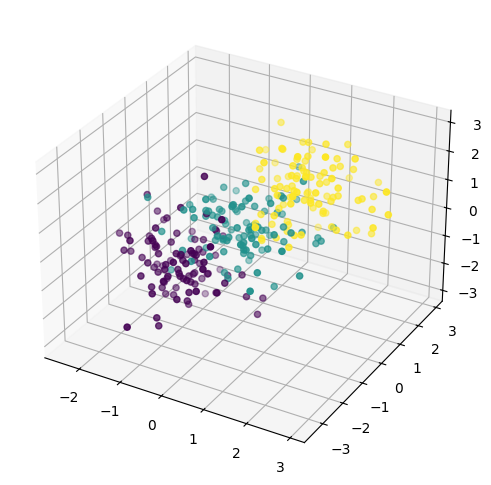

In [3]:
# Crear dataset con 3 clases
n_features=3
X, y = make_blobs(n_samples=300, centers=[[-1]*n_features, [0]*n_features, [1]*n_features], cluster_std=0.75, random_state=42)

# Plotear dataset
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
plt.show()


**Se pide:**
- Divide el dataset en conjuntos de entrenamiento y test mediante la función `train_test_split`. Utiliza el 20% de las muestras para test y el 80% restante para entrenamiento.
- Emplea un clasificador `SVC` para abordar el problema propuesto mediante la estrategia **OvO**.
- Encuentra los hiperparámetros que ofrezcan mejores resultados con el conjunto de entrenamiento. Utiliza para ello `GridSearchCV`.
- Muestra los resultados obtenidos con el conjunto de entrenamiento para cada uno de los hiperparámetros analizados. Utiliza para ello la función `show_results_gs` que se da más abajo.
- Muestra los resultados obtenidos con el conjunto de test en el mejor modelo. Utiliza para ello la función `classification_report(y_test, y_pred)` del módulo `sklearn.metrics` la cual muestra tanto el *accuracy* como otras métricas (*precision*, *recall*, *f1-score*).

Deberías lograr un *accuracy* en el conjunto de test en torno a 0.85.

In [15]:
def show_results_gs(gs, sort=False):
    # Extraer los resultados del GridSearchCV
    results = gs.cv_results_

    # Crear un DataFrame con los parámetros y los resultados medios
    df_results = pd.DataFrame({
        'mean_test_score': results['mean_test_score'],
        'params': results['params']
    })

    # Ordenar los resultados por el resultado promedio (opcional)
    if sort:
        df_results = df_results.sort_values(by='mean_test_score', ascending=False)

    # Mostrar los resultados
    print(df_results)  

In [ ]:
# ESCRIBE AQUÍ TU SOLUCIÓN

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=23)

model = SVC(kernel='linear',decision_function_shape='ovo')
#scaler = StandardScaler()
#pipe = Pipeline([("scaler", scaler), ("svm", model)])

params = {'C':[0.01, 0.1, 0.5, 0.75, 1], 'kernel':['linear', 'rbf'], 'gamma':[0.05, 0.1, 0.5, 1]}
gs = GridSearchCV(model, params, cv=5)
gs.fit(X_train, y_train)


print('Resultados con el conjunto de entrenamiento:')
show_results_gs(gs, True)

best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)

# Evalúa el modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)
print('\nResultados con el conjunto de test:')
print(classification_report(y_test, y_pred))

Resultados con el conjunto de entrenamiento:
    mean_test_score                                          params
8          0.957635   {'C': 0.1, 'gamma': 0.05, 'kernel': 'linear'}
10         0.957635    {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
12         0.957635    {'C': 0.1, 'gamma': 0.5, 'kernel': 'linear'}
14         0.957635      {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
38         0.950493        {'C': 1, 'gamma': 1, 'kernel': 'linear'}
36         0.950493      {'C': 1, 'gamma': 0.5, 'kernel': 'linear'}
34         0.950493      {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
32         0.950493     {'C': 1, 'gamma': 0.05, 'kernel': 'linear'}
20         0.943596    {'C': 0.5, 'gamma': 0.5, 'kernel': 'linear'}
16         0.943596   {'C': 0.5, 'gamma': 0.05, 'kernel': 'linear'}
30         0.943596     {'C': 0.75, 'gamma': 1, 'kernel': 'linear'}
28         0.943596   {'C': 0.75, 'gamma': 0.5, 'kernel': 'linear'}
26         0.943596   {'C': 0.75, 'gamma': 0.1, 'kernel': 'linear'}
24 

In [7]:
# Cargar el dataset breast cancer y mostrar una descripción básica del mismo
data = load_breast_cancer()
X = data.data  
y = data.target
feature_names = data.feature_names

# Crear un DataFrame
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

print(df.describe())

# Distribución de la variable objetivo
print('Balanceo de clases')
print(df['target'].value_counts())

       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%      

### Ejercicio 5. Problemas con un conjuntos de datos reales: 
- **Dataset Breast Cancer**
- **Dataset Wine**

Objetivos: 
- Trabajar con datasets reales y encontrar el mejor clasificador SVM.
- Trabajar con conjuntos de datos balanceados y desbalanceados y obtener resultados con distintas métricas.

#### 5.1. Dataset Breast Cancer

El dataset *Breast Cancer*  contiene información obtenida de imágenes digitalizadas de biopsias de cáncer de mama. Se utiliza para predecir si un tumor es benigno (clase 1) o maligno (ckase 0) en función de diversas características extraídas de las imágenes como el radio del tumor, el perímetro, el área, ...

**Se pide:**

1. Con el código que se da más abajo, carga el dataset *breast cancer* y obtén una descripción básica del mismo para ver qué tipo de características contiene. En función de eso decide si necesitas hacer algún preproceso de estos datos (mediante Pipeline) antes de usarlos como entrada de un clasificador.
1. A continuación crea conjuntos de entrenamiento (80%) y test (20%) y encuentra el mejor clasificador SVM para este dataset.
1. Muestra los resultados obtenidos en el conjunto de entrenamiento con los distintos hiperparámetros.
1. Muestra los resultados obtenidos en el conjunto de entrenamiento con los distintos hiperparámetros.
1. Muestra el resultado obtenido (precision, recall, f1-score, accuracy) en el conjunto de test con el mejor clasificador. Usa para ello la función `classification_report` 

In [8]:
# Cargar el dataset breast cancer y mostrar una descripción básica del mismo
data = load_breast_cancer()
X = data.data  
y = data.target
feature_names = data.feature_names

# Crear un DataFrame
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

print(df.describe())

# Distribución de la variable objetivo
print('Balanceo de clases')
print(df['target'].value_counts())

       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%      

In [ ]:
# ESCRIBE AQUÍ TU SOLUCIÓN

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
svc = SVC()
pipe = Pipeline([('scaler', scaler), ('svc', svc)])

params = {'svc__kernel':['linear', 'poly', 'rbf'], 'svc__C':[0.01,0.1,1,10],'svc__gamma':[0.01,0.05, 0.1, 0.5, 1]}

gs = GridSearchCV(pipe, params, cv=5, verbose=10)
gs.fit(X_train, y_train)
print(gs.best_params_)

print('Resultados con el conjunto de entrenamiento:')
show_results_gs(gs, True)

best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)

# Evalúa el modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)
print('\nResultados con el conjunto de test:')
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5; 1/60] START svc__C=0.01, svc__gamma=0.01, svc__kernel=linear...........
[CV 1/5; 1/60] END svc__C=0.01, svc__gamma=0.01, svc__kernel=linear;, score=1.000 total time=   0.0s
[CV 2/5; 1/60] START svc__C=0.01, svc__gamma=0.01, svc__kernel=linear...........
[CV 2/5; 1/60] END svc__C=0.01, svc__gamma=0.01, svc__kernel=linear;, score=1.000 total time=   0.0s
[CV 3/5; 1/60] START svc__C=0.01, svc__gamma=0.01, svc__kernel=linear...........
[CV 3/5; 1/60] END svc__C=0.01, svc__gamma=0.01, svc__kernel=linear;, score=1.000 total time=   0.0s
[CV 4/5; 1/60] START svc__C=0.01, svc__gamma=0.01, svc__kernel=linear...........
[CV 4/5; 1/60] END svc__C=0.01, svc__gamma=0.01, svc__kernel=linear;, score=0.929 total time=   0.0s
[CV 5/5; 1/60] START svc__C=0.01, svc__gamma=0.01, svc__kernel=linear...........
[CV 5/5; 1/60] END svc__C=0.01, svc__gamma=0.01, svc__kernel=linear;, score=1.000 total time=   0.0s
[CV 1/5; 2/60] START svc__C=

#### 5.2. Dataset Wine

El dataset *Wine* contiene variables relacionadas con el análisis químico de vinos italianos provenientes de tres variedades diferentes. Su objetivo es clasificar cada muestra de vino en una de esas tres variedades. Se trata, por tanto, de un problema multiclase.

El dataset contiene 178 observaciones y 13 características como son la cantidad de alcohol, cenizas, magnesio, fenoles, ...

**Se pide** hacer un análisis similar al realizado con el dataset de *breast cancer*.

In [10]:
# ESCRIBE TU SOLUCIÓN AQUÍ

wine = load_wine()
X = wine.data  
y = wine.target
feature_names = wine.feature_names

# Crear un DataFrame
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

print(df.describe())

# Distribución de la variable objetivo
print('Balanceo de clases')
print(df['target'].value_counts())

          alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.557500          21.500000  107.000000   
max     14.830000    5.800000    3.230000          30.000000  162.000000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.124453         0.572359   
min         0.9

In [11]:
# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
svc = SVC()
pipe = Pipeline([('scaler', scaler), ('svc', svc)])

params = {'svc__C':[0.01,0.1,1,10], 'svc__kernel':['rbf', 'poly'], 'svc__gamma':[0.01,0.05, 0.1, 0.5, 1]}

gs = GridSearchCV(pipe, params, cv=5)
gs.fit(X_train, y_train)

print('Resultados con el conjunto de entrenamiento:')
show_results_gs(gs, True)

best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)

# Evalúa el modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)
print('\nResultados con el conjunto de test:')
print(classification_report(y_test, y_pred))

Resultados con el conjunto de entrenamiento:
    mean_test_score                                             params
20         0.978818  {'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel...
22         0.978818  {'svc__C': 1, 'svc__gamma': 0.05, 'svc__kernel...
24         0.971921  {'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel'...
12         0.971675  {'svc__C': 0.1, 'svc__gamma': 0.05, 'svc__kern...
34         0.964778  {'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel...
32         0.964778  {'svc__C': 10, 'svc__gamma': 0.05, 'svc__kerne...
37         0.964532  {'svc__C': 10, 'svc__gamma': 0.5, 'svc__kernel...
35         0.964532  {'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel...
29         0.964532  {'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': ...
27         0.964532  {'svc__C': 1, 'svc__gamma': 0.5, 'svc__kernel'...
19         0.964532  {'svc__C': 0.1, 'svc__gamma': 1, 'svc__kernel'...
17         0.964532  {'svc__C': 0.1, 'svc__gamma': 0.5, 'svc__kerne...
39         0.964532  {'svc__C': 